In [1]:
using Random, Distributions
include("Box_Neumann_To_Dirichlet.jl")

Generate_Input_Output (generic function with 2 methods)

# Generate Dirichlet results for box setup

The computational domain is $[0,1]\times[0,1]$.



Assume the wave speed is $c(x,y)$.
Consider the Neumann boundary $\frac{\partial u}{\partial n} = u_n(x)$ on the top, and $\frac{\partial u}{\partial n} = 0$ in all 
other boundaries.

The top Neumann boundary is 
$$u_n(x) = 1_{|x - x_0| < \frac{d_0}{2}}$$

The source term is $0$.


The ouput is a $N_p \times 3 \times 4$ tensor, which contains triplet (x, Neumann result, Dirichlet result) on four boundaries.


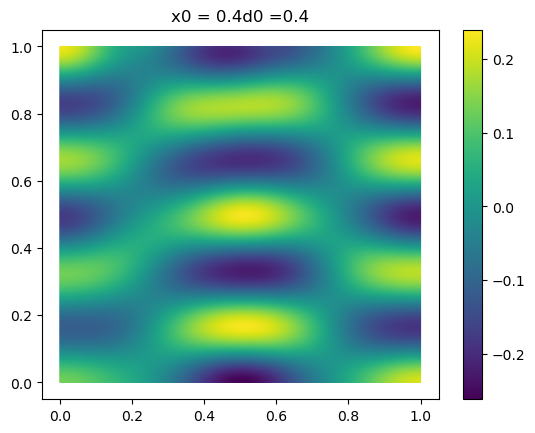

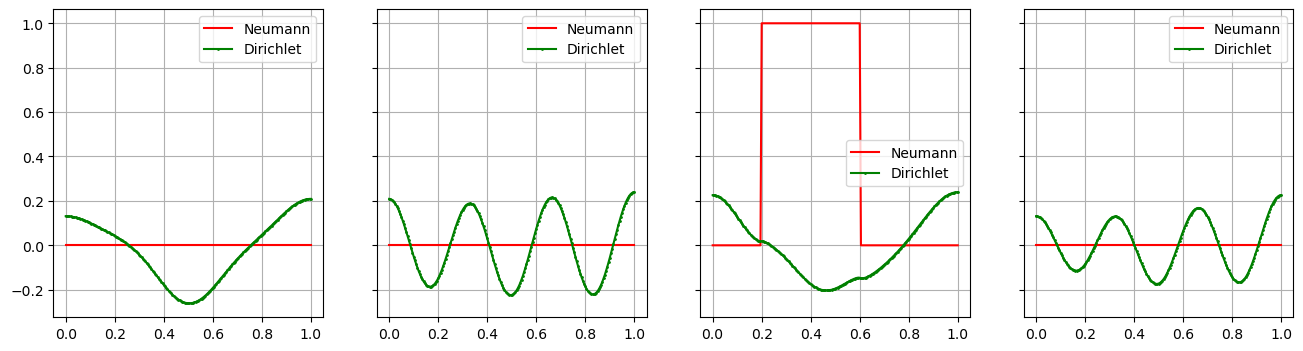

In [2]:
x0, d0 = 0.4, 0.4
c_func = (x, y)->50 #(1 + x^2 + y^2)
ne = 200
porder = 1

data = N2D(x0, d0, c_func, ne, ne, porder, 3; visualize = true)

fig_disp, ax_disp = PyPlot.subplots(ncols = 4, nrows=1, sharex=false, sharey=true, figsize=(16,4))
markersize = 1

for bc_id = 1:4
    
    ax_disp[bc_id].plot(data[:, 1, bc_id], data[:, 2, bc_id], "-r", markersize = markersize, label="Neumann")
    ax_disp[bc_id].plot(data[:, 1, bc_id], data[:, 3, bc_id], "-go", markersize = markersize, label="Dirichlet")
    
    ax_disp[bc_id].grid()
    ax_disp[bc_id].legend()
end 
    

# Kernel for the Neumann to the Dirichlet Map

The solution on the top is  $u_d$, and is assumed to be  
$$
\begin{align*}
u_d(y) &= \int_{y\in\partial D} u_n(x) \kappa(y, x; c) dx\\
       &= \int_{0}^{1} u_n(x) \kappa(y, x; c) dx\\
\end{align*}
$$
here the kernel function $\kappa$ depends on $c(x,y)$.

Assume the element mesh size is $\Delta x$, and we have $N_e$ element in each direction.  

For first order finite element approximation, we have 
$$
\begin{align*}
u_d(y) &= \int_{y\in\partial D} u_n(x) \kappa(y, x) dx\\
       &= \int_{0}^{1} u_n(x) \kappa(y, x) dx\\
       &\approx \sum_{i=1}^{N_e} \Delta x \Big(\frac{\kappa(y, x_i) u_n(x_i)}{2} + \frac{\kappa(y, x_{i+1}) u_n(x_{i+1})}{2}\Big)\\
       &\approx \Delta x \Big(\frac{\kappa(y, x_1) u_n(x_1)}{2} + \kappa(y, x_2) u_n(x_2) + \kappa(y, x_3) u_n(x_3) + \cdots \kappa(y, x_{N_e}) u_n(x_{N_e}) + \frac{\kappa(y, x_{N_e + 1}) u_n(x_{N_e + 1})}{2}\Big)
\end{align*}
$$

For second order finite element approximation, we have 
$$
\begin{align*}
u_d(y) &= \int_{y\in\partial D} u_n(x) \kappa(y, x) dx\\
       &= \int_{0}^{1} u_n(x) \kappa(y, x) dx\\
       &\approx \sum_{i=1}^{N_e} \Delta x \Big(\frac{\kappa(y, x_{2i-1}) u_n(x_{2i-1})}{6} + \frac{4\kappa(y, x_{2i}) u_n(x_{2i})}{6} + \frac{\kappa(y, x_{2i+1}) u_n(x_{2i+1})}{6}\Big)\\
       &\approx \Delta x \Big(\frac{\kappa(y, x_1) u_n(x_1)}{6} + \frac{4\kappa(y, x_2) u_n(x_2)}{6} + \frac{2\kappa(y, x_3) u_n(x_3)}{6} + \cdots \frac{4\kappa(y, x_{2N_e}) u_n(x_{2N_e})}{6} + \frac{\kappa(y, x_{2N_e + 1}) u_n(x_{2N_e + 1})}{6}\Big)
\end{align*}
$$


To recover the $\kappa$, we can compute the matrix $K$ from pairs $\{u_n, u_d\}$ by solving a least square problem and scale back the $\kappa(x_i, x_j)$.




The data is a $N_p \times 3 \times 4 \times N_cN_l$ tensor, number of nodal points in each boundary, triplet of (x, Neumman result, Dirichlet result), and four boundaries.


## Recover $\kappa(x_i, x_j; c)$ for fixed $c(x,y)$

To recover the $\kappa(x_i, y_j)$, 
* compute the matrix $K_{ij}$ from pairs $\{u_n, u_d\}$ by solving a least square problem 
* scale back the $\kappa(x_i, x_j)$ with 
$$
\begin{align*}
    &\Big[\frac{\Delta x}{2}; \Delta x; \Delta x; \Delta x; \cdots; \Delta x; \frac{\Delta x}{2}\Big]\\
    &\Big[\frac{\Delta x}{6}; \frac{4\Delta x}{6}; \frac{2\Delta x}{6}; \frac{4\Delta x}{6};\cdots; \frac{4\Delta x}{6}; \frac{\Delta x}{6}\Big]\\
\end{align*}
$$


We fix $c(x,y) = 50$.

We generate $N_l = 200$ inputs based on $x_0 \sim U[0,1]$ and $d_0 \sim U[0, 1]$. If the random pair $(x_0,d_0)$ would lead to a bump that exceeds the boundary, it is cut off at the edge of the square.

In [3]:
N_l = 300
x0d0s = rand(Uniform(0,1), N_l,2);

cs = [(x,y)->50.0;]

1-element Array{var"#41#42",1}:
 #41 (generic function with 1 method)

In [4]:
x0d0s[1, :]

2-element Array{Float64,1}:
 0.5830800111073609
 0.4871906344731518

### First order approximation 

The data is a $N_p \times 3 \times 4 \times N_cN_l$ tensor, number of nodal points in each boundary, 
triplet of (x, Neumman result, Dirichlet result), and four boundaries.

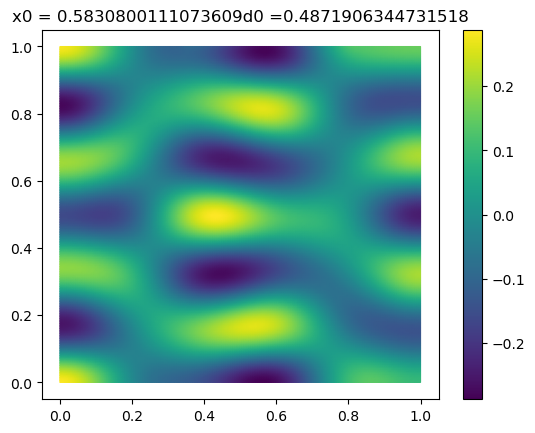

In [5]:
# 100 element in each direction
ne =  200
porder = 1
Δx = 1.0/ne
K_scale = zeros(Float64, ne*porder+1) .+ Δx
K_scale[1] = K_scale[end] = Δx/2.0

# generate Dirichlet to Neumman results output for different conditions
# data =[nodal positions, (x, ∂u∂n, u), 4 edges, experiment number]
data = Generate_Input_Output(cs,  x0d0s, ne, porder);



* Regression to obtain the matrix operator
```
Kdx = u_d/u_n
```
* Scale back
```
K = Kdx ./ K_scale 
```
 

In [6]:
# data =[nodal positions, (x, ∂u∂n, u), 4 edges, experiment number]
bc_id = 3
u_n = data[:, 2, bc_id, :]
u_d = data[:, 3, bc_id, :]

# train on 80% of data, test on 20%
num_train = ceil(Int,0.8*N_l)
Kdx = u_d[:,1:num_train]/u_n[:,1:num_train]
K = Kdx ./ K_scale' 

@info "Training Error is ||Kdx*u_n - u_d|| = ", norm(Kdx*u_n[:,1:num_train] - u_d[:,1:num_train])
@info "Test Error is ||Kdx*u_n - u_d|| = ", norm(Kdx*u_n[:,num_train+1:end] - u_d[:,num_train+1:end])
PyPlot.close("all")
PyPlot.figure()
PyPlot.imshow(K, cmap=:RdBu)
PyPlot.colorbar()

PyPlot.figure()


U, Σ, Vt = svd(u_d);
PyPlot.semilogy(Σ, label = "Dirichlet")

U, Σ, Vt = svd(u_n);
PyPlot.semilogy(Σ, label = "Neumann")

U, Σ, Vt = svd(K);
PyPlot.semilogy(Σ, label = "Kernel")
PyPlot.legend()

┌ Info: ("Training Error is ||Kdx*u_n - u_d|| = ", 1.937875975583671e-11)
└ @ Main In[6]:11
┌ Info: ("Test Error is ||Kdx*u_n - u_d|| = ", 0.013603771574102377)
└ @ Main In[6]:12


LoadError: UndefVarError: κ not defined

### Second order approximation 

The data is a $N_p \times 3 \times 4 \times N_cN_l$ tensor, number of nodal points in each boundary, 
triplet of (x, Neumman result, Dirichlet result), and four boundaries.

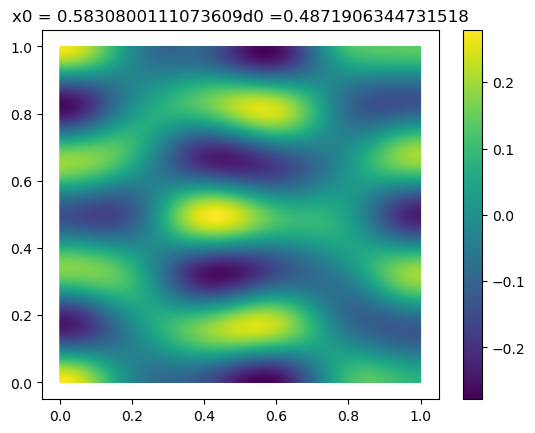

In [8]:
# 50 element in each direction
ne =  100
porder = 2
Δx = 1.0/ne
K_scale = zeros(Float64, ne*porder+1) 
for i = 1:ne
    K_scale[2i-1] = 2Δx/6
    K_scale[2i] = 4Δx/6
end
K_scale[1] = K_scale[end] = Δx/6.0

# generate Dirichlet to Neumman results output for different conditions
# data =[nodal positions, (x, ∂u∂n, u), 4 edges, experiment number]
data = Generate_Input_Output(cs,  x0d0s, ne, porder);

* Regression to obtain the matrix operator
```
Kdx = u_d/u_n
```
* Scale back
```
K = Kdx ./ K_scale 
```
 

In [9]:
# data =[nodal positions, (x, ∂u∂n, u), 4 edges, experiment number]
bc_id = 3
u_n = data[:, 2, bc_id, :]
u_d = data[:, 3, bc_id, :]


num_train = ceil(Int,0.8*N_l)
Kdx = u_d[:,1:num_train]/u_n[:,1:num_train]
K = Kdx ./ K_scale' 

@info "Training Error is ||Kdx*u_n - u_d|| = ", norm(Kdx*u_n[:,1:num_train] - u_d[:,1:num_train])
@info "Test Error is ||Kdx*u_n - u_d|| = ", norm(Kdx*u_n[:,num_train+1:end] - u_d[:,num_train+1:end])

PyPlot.figure()
PyPlot.imshow(K, cmap=:RdBu)
PyPlot.colorbar()

PyPlot.figure()


U, Σ, Vt = svd(u_d);
PyPlot.semilogy(Σ, label = "Dirichlet")

U, Σ, Vt = svd(u_n);
PyPlot.semilogy(Σ, label = "Neumann")

U, Σ, Vt = svd(κ);
PyPlot.semilogy(Σ, label = "Kernel")
PyPlot.legend()

┌ Info: ("Training Error is ||Kdx*u_n - u_d|| = ", 4.287947861154549e-12)
└ @ Main In[9]:11
┌ Info: ("Test Error is ||Kdx*u_n - u_d|| = ", 0.061313134084240224)
└ @ Main In[9]:12


LoadError: UndefVarError: κ not defined

### We will use only first order porder=1 in the future 